In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import statsmodels.api as sma

In [3]:
df=pd.read_excel(r"Concrete_Data.xls")

In [177]:
df.head()

,Cement,Slag,Fly_Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,CCS
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [178]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
Slag,1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
Fly_Ash,1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
Water,1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
Superplasticizer,1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
Coarse Aggregate,1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
Fine Aggregate,1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
Age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
CCS,1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225


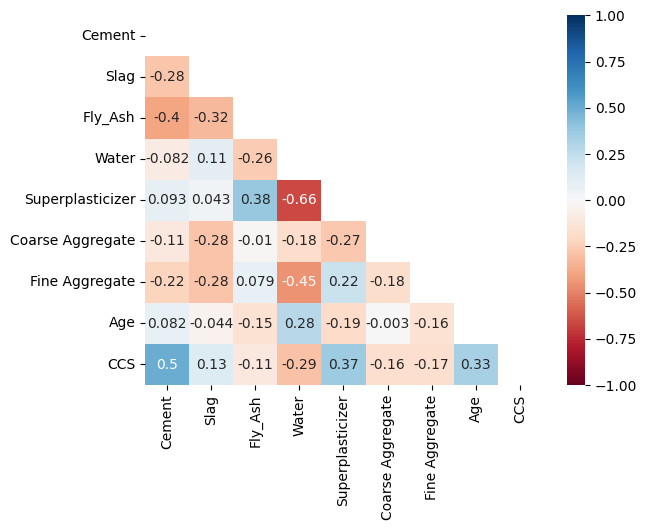

In [179]:
sns.heatmap(df.corr(),annot=True,vmax=1,vmin=-1,cmap='RdBu',mask=np.triu(df.corr()))
plt.show()

## Treat the defects

In [180]:
# Missing Value
df.isnull().sum()

Cement              0
Slag                0
Fly_Ash             0
Water               0
Superplasticizer    0
Coarse Aggregate    0
Fine Aggregate      0
Age                 0
CCS                 0
dtype: int64

In [181]:
# DUPLICATES

df.drop_duplicates(inplace=True)


In [182]:
# Capping the outliers 
for i in df.columns:
    q3,q1=np.percentile(df[i],[75,25])
    iqr=q3-q1
    ul=q3+1.5*iqr
    ll=q1-1.5*iqr

    df[i]=df[i].apply(lambda x:ul if x > ul else ll if x < ll else x )


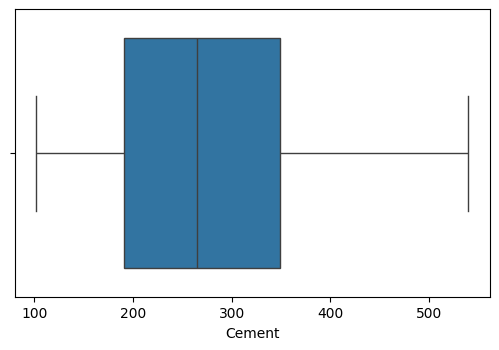

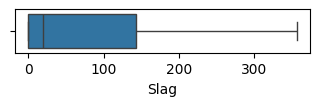

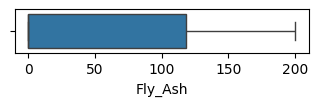

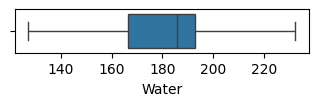

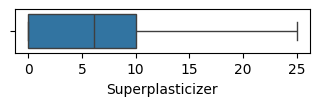

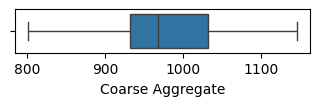

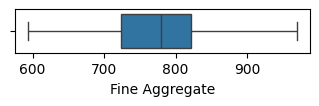

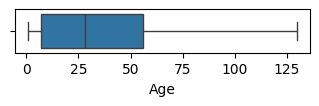

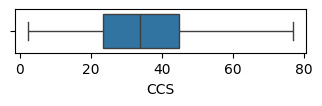

In [183]:
# Check for the outliers

t=1
plt.figure(figsize=(10,17))
for i in df.columns:
    plt.subplot(5,2,t)
    sns.boxplot(x=df[i])
    t=+1
    plt.tight_layout()
    plt.show()


## LINEAR Regression Analysis

In [184]:
x=df.drop(columns='CCS')
y=df['CCS']

In [185]:
df['Cemwat']=df['Cement']/df['Water']

In [186]:
model=sma.OLS(y,sma.add_constant(x))

##### Assumption 1 : Target Variable must be Numeric

Th Target is numeric

#### Assumption 2 : The data is not Multicolinerar

We treat the multicolineariry

In [187]:
x=df.drop(columns=['Water','Cement','Coarse Aggregate','CCS','Fine Aggregate'])

In [188]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_list=[]
#x.drop(columns=['Cement','Water'],inplace=True)
for i in range(x.shape[1]):
    vif_list.append(vif(x.values,i))

vif_df=pd.DataFrame({'VIF':vif_list},index=x.columns)
vif_df.sort_values(ascending=False,by='VIF')

,VIF
Superplasticizer,3.478069
Cemwat,3.260167
Fly_Ash,2.115637
Age,1.970481
Slag,1.484503


### Fit a mdoel

In [191]:
model=sma.OLS(y,sma.add_constant(x)).fit()

In [192]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CCS   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     493.3
Date:                Fri, 30 Aug 2024   Prob (F-statistic):          7.66e-267
Time:                        11:56:04   Log-Likelihood:                -3600.7
No. Observations:                1005   AIC:                             7213.
Df Residuals:                     999   BIC:                             7243.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -14.4833      1.309  

#### Assumption 3 Liner Retaion 

In [193]:
from statsmodels.stats.diagnostic import linear_rainbow

# H0: variables are linear
# H1: variables are not linear

linear_rainbow(model)

# Raject Ho

(np.float64(1.2250395980368607), np.float64(0.011777871160917037))

#### Assumption 4: Auto Correlation



In [194]:
# Durbin watson 
d=1.266

# Positive Correlation

#### Assumption 5 Homocedasticity

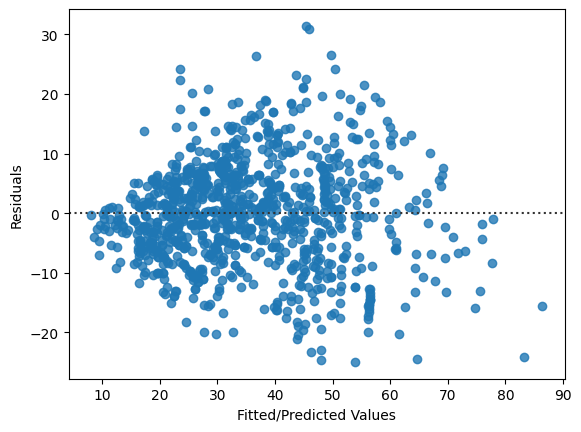

In [195]:
# resid plot

sns.residplot(x=model.fittedvalues,y=model.resid)
plt.xlabel('Fitted/Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [196]:
# we can make the final conclusion by performing Breusch-Pagan Test 

# H0 : The variance is same (Homoscedastic)
# H1 : The variance is not same (HetroScedastic)

_,p_value,_,_=sma.stats.diagnostic.het_breuschpagan(resid=model.resid ,exog_het=model.model.exog)


if p_value>0.05:
    print('Failed to reject H0')
else:
    print("Rejct H0")

Rejct H0


### Assumption 6 
Residual must be normal

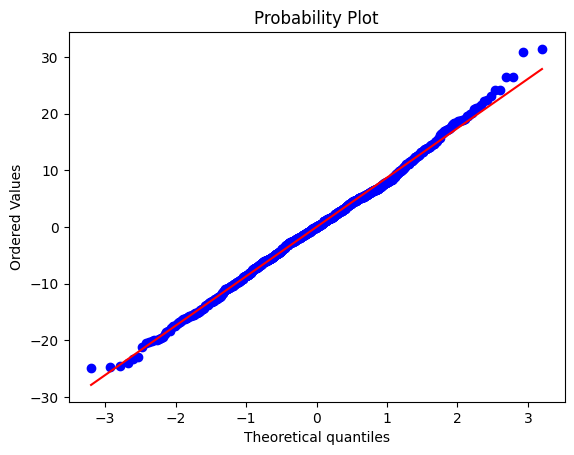

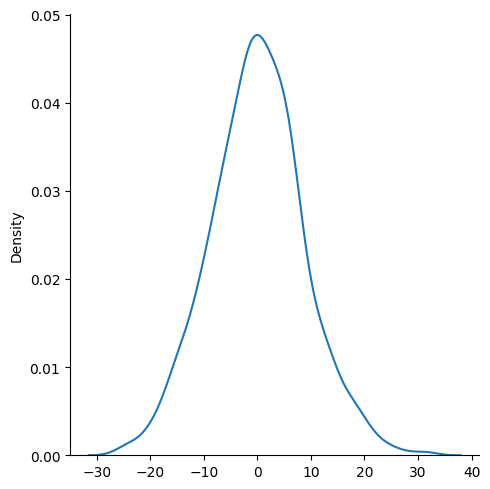

In [197]:
## QQ PLOT 
stats.probplot(model.resid,plot=plt)
sns.displot(model.resid,kind='kde')
plt.show()

In [198]:
# Shapiro Test 

# H0 : Residue is Normal
# H1 : Residue is Not Normal

_,p_value=stats.shapiro(model.resid)

if p_value>0.05:
    print('Failed to reject H0')
else:
    print("Rejct H0")

Failed to reject H0


In [199]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CCS   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     493.3
Date:                Fri, 30 Aug 2024   Prob (F-statistic):          7.66e-267
Time:                        11:56:08   Log-Likelihood:                -3600.7
No. Observations:                1005   AIC:                             7213.
Df Residuals:                     999   BIC:                             7243.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -14.4833      1.309  

#### Predecting Modelling

In [200]:
from sklearn.linear_model import LinearRegression ,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split

In [201]:
x_train ,x_test , y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=2)

## linear Regression

In [202]:
model_lr=LinearRegression()
model_lr.fit(x_train,y_train)
y_lr_train = model_lr.predict(x_train)
y_lr_test=model_lr.predict(x_test)

In [203]:
# Train score

print('R-Squared',r2_score(y_train,y_lr_train))
print('MSE',mean_squared_error(y_train,y_lr_train))
print('RMSE',mean_squared_error(y_train,y_lr_train)**0.5)
print('MAE',mean_absolute_error(y_train,y_lr_train))
print('MPAE',mean_absolute_percentage_error(y_train,y_lr_train))



R-Squared 0.713053912579235
MSE 76.24917904365789
RMSE 8.732077590336557
MAE 6.832892808268411
MPAE 0.2548672701668985


In [204]:
# Test Score (2-76)

print('R-Squared',r2_score(y_test,y_lr_test))
print('MSE',mean_squared_error(y_test,y_lr_test))
print('RMSE',mean_squared_error(y_test,y_lr_test)**0.5)
print('MAE',mean_absolute_error(y_test,y_lr_test))
print('MAPE',mean_absolute_percentage_error(y_test,y_lr_test))

R-Squared 0.7022495753418871
MSE 74.7860924690671
RMSE 8.64789526237842
MAE 6.737833931881046
MAPE 0.24561267571769127


In [205]:
model_lr.intercept_

np.float64(-15.20803202027168)

In [206]:
pd.DataFrame({'Coef':model_lr.coef_},index=x.columns)

,Coef
Slag,0.081387
Fly_Ash,0.078953
Superplasticizer,0.196101
Age,0.239964
Cemwat,19.171895


# Regularization

#### Ridge Regularisation (L2 Penalty)

In [207]:
model_ridge=Ridge(alpha=0.1)
model_ridge.fit(x_train,y_train)
y_ridge_train = model_ridge.predict(x_train)
y_ridge_test=model_ridge.predict(x_test)

In [208]:
# Train score

print('R-Squared',r2_score(y_train,y_ridge_train))
print('MSE',mean_squared_error(y_train,y_ridge_train))
print('RMSE',mean_squared_error(y_train,y_ridge_train)**0.5)
print('MAE',mean_absolute_error(y_train,y_ridge_train))
print('MPAE',mean_absolute_percentage_error(y_train,y_ridge_train))


print('\n')


print('R-Squared',r2_score(y_test,y_ridge_test))
print('MSE',mean_squared_error(y_test,y_ridge_test))
print('RMSE',mean_squared_error(y_test,y_ridge_test)**0.5)
print('MAE',mean_absolute_error(y_test,y_ridge_test))
print('MAPE',mean_absolute_percentage_error(y_test,y_ridge_test))

R-Squared 0.7130537986977157
MSE 76.24920930499529
RMSE 8.732079323104852
MAE 6.8329409010188265
MPAE 0.25489726050310135


R-Squared 0.7022915090371958
MSE 74.77555996615455
RMSE 8.647286277564456
MAE 6.737369065821287
MAPE 0.24563623336617735


In [209]:
pd.DataFrame({'Coef_lr':model_lr.coef_,'Coef_l2':model_ridge.coef_},index=x.columns)

,Coef_lr,Coef_l2
Slag,0.081387,0.081339
Fly_Ash,0.078953,0.078862
Superplasticizer,0.196101,0.196952
Age,0.239964,0.239957
Cemwat,19.171895,19.159188


### Lasso Regression (l1 )

In [210]:
model_Lasso=Lasso(alpha=.1)
model_Lasso.fit(x_train,y_train)
y_lasso_train = model_Lasso.predict(x_train)
y_lasso_test=model_Lasso.predict(x_test)

In [211]:
# Train score

print('R-Squared',r2_score(y_train,y_lasso_train))
print('MSE',mean_squared_error(y_train,y_lasso_train))
print('RMSE',mean_squared_error(y_train,y_lasso_train)**0.5)
print('MAE',mean_absolute_error(y_train,y_lasso_train))
print('MPAE',mean_absolute_percentage_error(y_train,y_lasso_train))


print('\n')


print('R-Squared',r2_score(y_test,y_lasso_test))
print('MSE',mean_squared_error(y_test,y_lasso_test))
print('RMSE',mean_squared_error(y_test,y_lasso_test)**0.5)
print('MAE',mean_absolute_error(y_test,y_lasso_test))
print('MAPE',mean_absolute_percentage_error(y_test,y_lasso_test))

R-Squared 0.712873405783417
MSE 76.29714448245043
RMSE 8.734823666362729
MAE 6.841206392567325
MPAE 0.25651314669727937


R-Squared 0.7037417455153137
MSE 74.41130349371099
RMSE 8.626198669965293
MAE 6.7189047367917025
MAPE 0.2465958897044756


In [212]:
pd.DataFrame({'Coef_lr':model_lr.coef_,'Coef_l2':model_ridge.coef_,'coef_l1':model_Lasso.coef_},index=x.columns)

,Coef_lr,Coef_l2,coef_l1
Slag,0.081387,0.081339,0.079472
Fly_Ash,0.078953,0.078862,0.075480
Superplasticizer,0.196101,0.196952,0.226244
Age,0.239964,0.239957,0.239585
Cemwat,19.171895,19.159188,18.667916


### Elastic Net

In [213]:
model_ec=ElasticNet(alpha=.1,l1_ratio=0.1)
model_ec.fit(x_train,y_train)
y_ec_train = model_ec.predict(x_train)
y_ec_test=model_ec.predict(x_test)

In [214]:
# Train score

print('R-Squared',r2_score(y_train,y_ec_train))
print('MSE',mean_squared_error(y_train,y_ec_train))
print('RMSE',mean_squared_error(y_train,y_ec_train)**0.5)
print('MAE',mean_absolute_error(y_train,y_ec_train))
print('MPAE',mean_absolute_percentage_error(y_train,y_ec_train))


print('\n')


print('R-Squared',r2_score(y_test,y_ec_test))
print('MSE',mean_squared_error(y_test,y_ec_test))
print('RMSE',mean_squared_error(y_test,y_ec_test)**0.5)
print('MAE',mean_absolute_error(y_test,y_ec_test))
print('MAPE',mean_absolute_percentage_error(y_test,y_ec_test))

R-Squared 0.6855842993456807
MSE 83.54858318097234
RMSE 9.140491408068405
MAE 7.173411012501002
MPAE 0.28256391475731113


R-Squared 0.6867445729087639
MSE 78.68049009092813
RMSE 8.870202370348048
MAE 6.949316411057378
MAPE 0.2680384677168505


In [215]:
pd.DataFrame({'Coef_lr':model_lr.coef_,'Coef_l2':model_ridge.coef_,'coef_l1':model_Lasso.coef_,'coef':model_ec.coef_},index=x.columns)

,Coef_lr,Coef_l2,coef_l1,coef
Slag,0.081387,0.081339,0.079472,0.057462
Fly_Ash,0.078953,0.078862,0.075480,0.034551
Superplasticizer,0.196101,0.196952,0.226244,0.612124
Age,0.239964,0.239957,0.239585,0.236761
Cemwat,19.171895,19.159188,18.667916,12.931118


## Hyperparameter Tuning

In [216]:
from sklearn.model_selection import GridSearchCV

In [217]:
grid={'alpha':[0.01,0.05,0.1,0.5,1],'l1_ratio':[0.05,0.1,0.2,0.3]}

gscv=GridSearchCV(estimator=ElasticNet(),param_grid=grid,cv=5,scoring='r2',verbose=3)

In [218]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .........alpha=0.01, l1_ratio=0.05;, score=0.718 total time=   0.0s
[CV 2/5] END .........alpha=0.01, l1_ratio=0.05;, score=0.708 total time=   0.0s
[CV 3/5] END .........alpha=0.01, l1_ratio=0.05;, score=0.721 total time=   0.0s
[CV 4/5] END .........alpha=0.01, l1_ratio=0.05;, score=0.676 total time=   0.0s
[CV 5/5] END .........alpha=0.01, l1_ratio=0.05;, score=0.710 total time=   0.0s
[CV 1/5] END ..........alpha=0.01, l1_ratio=0.1;, score=0.718 total time=   0.0s
[CV 2/5] END ..........alpha=0.01, l1_ratio=0.1;, score=0.707 total time=   0.0s
[CV 3/5] END ..........alpha=0.01, l1_ratio=0.1;, score=0.722 total time=   0.0s
[CV 4/5] END ..........alpha=0.01, l1_ratio=0.1;, score=0.676 total time=   0.0s
[CV 5/5] END ..........alpha=0.01, l1_ratio=0.1;, score=0.710 total time=   0.0s
[CV 1/5] END ..........alpha=0.01, l1_ratio=0.2;, score=0.718 total time=   0.0s
[CV 2/5] END ..........alpha=0.01, l1_ratio=0.2

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1],
                         'l1_ratio': [0.05, 0.1, 0.2, 0.3]},
             scoring='r2', verbose=3)

In [219]:
gscv.best_score_

np.float64(0.7067653126229594)

# Gradient Descent

In [220]:
# check scores from OLS model

print('OLS : Train Score',model_lr.score(x_train,y_train))

print('OLS : Test Score',model_lr.score(x_test,y_test))

OLS : Train Score 0.713053912579235
OLS : Test Score 0.7022495753418871


In [221]:
pd.DataFrame({'COef_OLS':model_lr.coef_},index=x.columns)

,COef_OLS
Slag,0.081387
Fly_Ash,0.078953
Superplasticizer,0.196101
Age,0.239964
Cemwat,19.171895


In [222]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [228]:
# use the scaled data
sc=StandardScaler()
x_train_s=sc.fit_transform(x_train)
x_test_s=sc.transform(x_test)

In [229]:
x_train_s=pd.DataFrame(x_train_s,columns=x.columns)
x_test_s=pd.DataFrame(x_test_s,columns=x.columns)

In [230]:
model_SGD=SGDRegressor(eta0=0.1,alpha=0.01)

In [231]:
model_SGD.fit(x_train_s,y_train)

SGDRegressor(alpha=0.01, eta0=0.1)

In [233]:
# Check the Score from Sgd model

print('SGD : Train Score',model_SGD.score(x_train_s,y_train))

print('SGD : Test Score',model_SGD.score(x_test_s,y_test))

SGD : Train Score 0.7086695489675494
SGD : Test Score 0.7100613906034703
